In [1]:
# Budilding a Convnet from Scratch

'''In this exercise, we will build a classifier model from scratch that is able to distinguish between cats and dogs. We will follow the following steps:
1. Explore the example data
2. Build a small convnet from scratch to solve our classification problem
3. Evaluate training and validation accuracy
'''

'In this exercise, we will build a classifier model from scratch that is able to distinguish between cats and dogs. We will follow the following steps:\n1. Explore the example data\n2. Build a small convnet from scratch to solve our classification problem\n3. Evaluate training and validation accuracy\n'

In [2]:
# Let's start by downloading our example data, a .zip of 2000 jpg pictures of cats and dogs, and extracting it locally in /tmp

# Note: The 2000 images used in this exercise are exercepted from the "Dogs vs Cats" dataset available on Kaggle, which contains 25000 images. Here, we use a subset of the full dataset to decrease training time 
# for educational purposes

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2024-10-23 15:05:18--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com... 172.253.63.207, 142.251.111.207, 142.251.16.207, ...
Connecting to storage.googleapis.com|172.253.63.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: '/tmp/cats_and_dogs_filtered.zip'

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  25.3MB/s    in 2.6s    

2024-10-23 15:05:21 (25.3 MB/s) - '/tmp/cats_and_dogs_filtered.zip' saved [68606236/68606236]



In [3]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [4]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [5]:
# Now let's see what the filenames look like in the cats and dogs train directories (file naming conventions are the smae in validation directory)

train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.952.jpg', 'cat.946.jpg', 'cat.6.jpg', 'cat.749.jpg', 'cat.991.jpg', 'cat.985.jpg', 'cat.775.jpg', 'cat.761.jpg', 'cat.588.jpg', 'cat.239.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


In [6]:
# Let's find out the total number of cat and dog images in the train and validation directories
print("total training cat images:", len(os.listdir(train_cats_dir)))
print("total training dog images:", len(os.listdir(train_dogs_dir)))
print('total validation cat images', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images 500
total validation dog images: 500


In [7]:
# For both cats and dogs we have 1000 training images and 500 test images
# Now let's take a look at a few pictures to get a better sense of what the cat and dog datasets look like. First, configure the matplot parameters

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

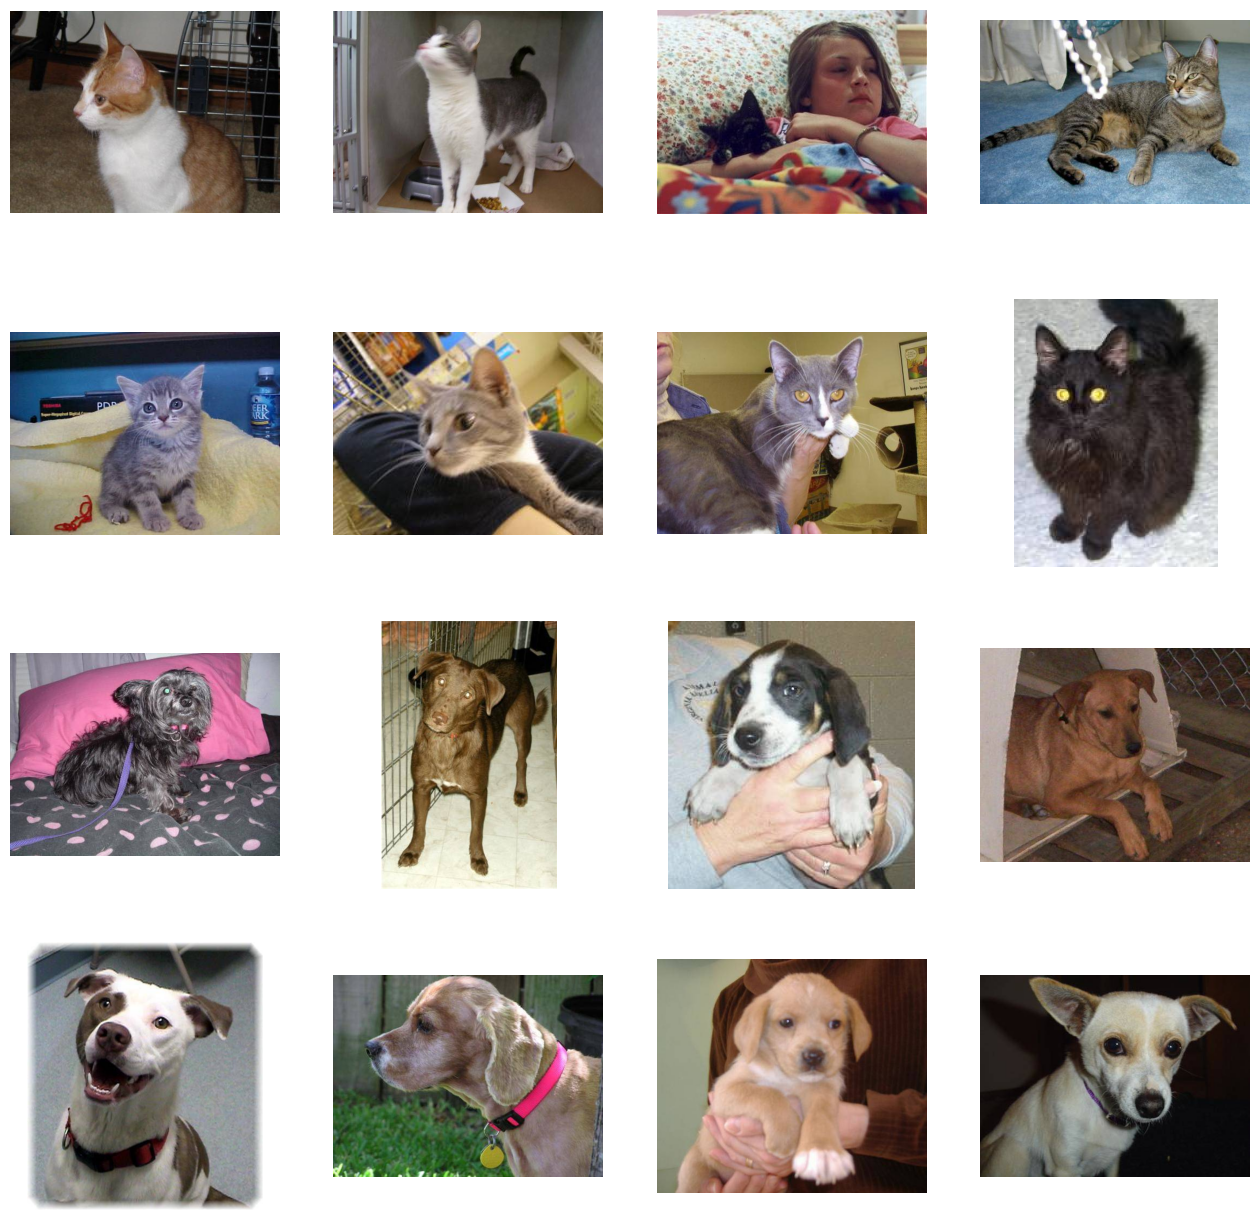

In [8]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname)
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname)
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix + next_dog_pix):
    # Set up the subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [9]:
# Building a Small Convnet from scratch to get to 72% accuracy

''' 
The images that will go into our convnet are 150x150 color images (in the next section on Data Preprocessing, we'll add handling to resize all the images to 150x150 before feeding them into the neural network)
Let's code up the atchitecture. We will stack 3 {convolution + relu + maxpooling} modules. Our convolutions operate 3x3 windows and our maxpooling layers operate on 2x2 windows. Our first convolution extracts
16 filters, the following one extracts 32 filters, and the last one extracts 64 filters.

Note: This is a configuration that is widely used and known to work well for image classification. Also, since we have relatively few training examples (1,000), using just three convolutional modules keeps the model
small, which lowers the risk of overfitting (which we'll explore in more depth in Exercise 2)
'''

" \nThe images that will go into our convnet are 150x150 color images (in the next section on Data Preprocessing, we'll add handling to resize all the images to 150x150 before feeding them into the neural network)\nLet's code up the atchitecture. We will stack 3 {convolution + relu + maxpooling} modules. Our convolutions operate 3x3 windows and our maxpooling layers operate on 2x2 windows. Our first convolution extracts\n16 filters, the following one extracts 32 filters, and the last one extracts 64 filters.\n\nNote: This is a configuration that is widely used and known to work well for image classification. Also, since we have relatively few training examples (1,000), using just three convolutional modules keeps the model\nsmall, which lowers the risk of overfitting (which we'll explore in more depth in Exercise 2)\n"

In [10]:
from tensorflow.keras import layers
from tensorflow.keras import Model

# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for the three color channels: R, G and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation="relu")(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-polling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation="relu")(x)
x = layers.MaxPooling2D(2)(x)


In [11]:
'''
On top of it we stick two fully connected layers. Because we are facing a two-class classification problem, i.e. a binary classification problem, we will end our netwrok with a sigmoid function, so that the output
of our network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0)
'''

# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Create output layer with a single ndoe and sigmoid activation
output = layers.Dense(1, activation="sigmoid")(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully connected layer + sigmoid output layer
model = Model(img_input, output)

In [12]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,470,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,494,561 (36.22 MB)

 Trainable params: 9,494,561 (36.22 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
'''
The 'output shape' column shows how the size of your feature map evolves in each successive layer. The convolution layers reduce the size of the feature map as there is no padding. Each pooling layer
halves the feature map

Next, we'll configure the specifications for model training. We will train our model with the binary_crossentropy loss, because its a binary classification problem and our final activation is a sigmoid. 
We will use the rmsprop optimizer with a learning rate of 0.001. During training, we will want to monitor classification accuracy. 

Note: In this case, using the RMSprop optimization algorithm is preferable to stochastic gradient descent, because RMSprop automates learning rate tuning for us. (Other optimizers, such as Adam and Adagrad, 
also automatically adapt the learning rate during training, and would work equally well here.)
'''

from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['acc'])

In [14]:
'''
Data Preprocessing 

Let's set up data generators that will read pictures in our source folders, covert them to float32 tensors, and feed them (with their labels) to our network. We will have one generator for the training images
and one for the training images and one for the validation images. Our generator will yield batches of 20 images of size 150x150 and their labels(binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In 
our case, we will preprocess our images by normalizing the pizel values to be in the [0, 1] range (originally all values are in the [0, 255] range)

In Keras this can be done via the keras.preprocessing.image.ImageDataGenerator class using the rescale parameter. This ImageDataGenerator class allows you to instantiate generators of augmented image batches ( and
their labels) via .flow(data, labels) or .flow_from_directory(directory). These generators can then be used with the Keras model methods that accept data generators as inputs: fit_generator, evaluate_generator, and 
predict_generator
'''

"\nData Preprocessing \n\nLet's set up data generators that will read pictures in our source folders, covert them to float32 tensors, and feed them (with their labels) to our network. We will have one generator for the training images\nand one for the training images and one for the validation images. Our generator will yield batches of 20 images of size 150x150 and their labels(binary).\n\nAs you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In \nour case, we will preprocess our images by normalizing the pizel values to be in the [0, 1] range (originally all values are in the [0, 255] range)\n\nIn Keras this can be done via the keras.preprocessing.image.ImageDataGenerator class using the rescale parameter. This ImageDataGenerator class allows you to instantiate generators of augmented image batches ( and\ntheir labels) via .flow(da

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir, # This is the source directory for training images
    target_size=(150, 150), # All images will be resized to 150x150
    batch_size=20,
    # Since we use binary_crossentropy loss, we need binary labels
    class_mode='binary'
)

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
    validation_dir, # This is the source directory for validation images
    target_size=(150, 150), # All images will be resized to 150x150
    batch_size=20,
    # Since we use binary_crossentropy loss, we need bianry labels
    class_mode = 'binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [22]:
# Let's train all 2,000 images available, for 15 epochs, and validate on all 1,000 validation images

history = model.fit(
    train_generator, 
    steps_per_epoch=100, # 2000 images = steps_per_epoch * batch_size
    epochs = 15, 
    validation_data=validation_generator,
    validation_steps=50, # 1000 images = batch_size * steps_per_epoch
    verbose=2
)

Epoch 1/15
100/100 - 12s - 117ms/step - acc: 0.9455 - loss: 0.1383 - val_acc: 0.7230 - val_loss: 0.7623
Epoch 2/15
100/100 - 0s - 361us/step - acc: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/15


2024-10-23 15:11:16.682557: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 - 11s - 106ms/step - acc: 0.9710 - loss: 0.0987 - val_acc: 0.7260 - val_loss: 0.9789
Epoch 4/15
100/100 - 0s - 106us/step - acc: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/15
100/100 - 11s - 108ms/step - acc: 0.9795 - loss: 0.0938 - val_acc: 0.7260 - val_loss: 1.0011
Epoch 6/15
100/100 - 0s - 104us/step - acc: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/15
100/100 - 12s - 121ms/step - acc: 0.9850 - loss: 0.0641 - val_acc: 0.7380 - val_loss: 1.1824
Epoch 8/15
100/100 - 0s - 214us/step - acc: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/15
100/100 - 12s - 115ms/step - acc: 0.9940 - loss: 0.0164 - val_acc: 0.7220 - val_loss: 1.4627
Epoch 10/15
100/100 - 0s - 123us/step - acc: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/15
100/100 - 12s - 119ms/step - acc: 0.9805 - loss: 0.0989 - val_acc: 0.7360 - val_loss: 1.1670
Epoch 12/15
100/100 - 0s - 115us/step - acc: 0.0000e+00 - loss: 0.0000e+00
Epoch 13/15
100/100 - 12s - 120ms/step - acc: 0.9980 - loss: 0.0086 - val_acc: 0.7250 - val_loss: 1.5536
Epoch 14/15
1

In [17]:
# Visualizing intermediate representations

'''
To get a feel for what kind of features our convnet has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the convnet

Let's pick a random cat or dog image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map.
'''

"\nTo get a feel for what kind of features our convnet has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the convnet\n\nLet's pick a random cat or dog image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map.\n"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


/var/folders/3q/y3lhffxj6dl1rxzx2yw0441m0000gn/T/ipykernel_24052/1322428653.py:43: RuntimeWarning: invalid value encountered in divide
  x /= x.std()
/var/folders/3q/y3lhffxj6dl1rxzx2yw0441m0000gn/T/ipykernel_24052/1322428653.py:46: RuntimeWarning: invalid value encountered in cast
  x = np.clip(x, 0, 255).astype('uint8')


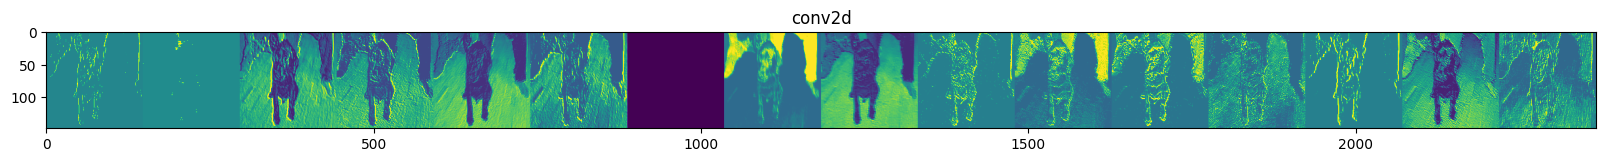

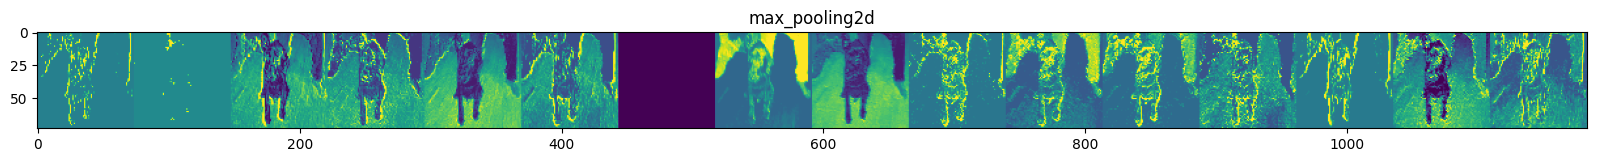

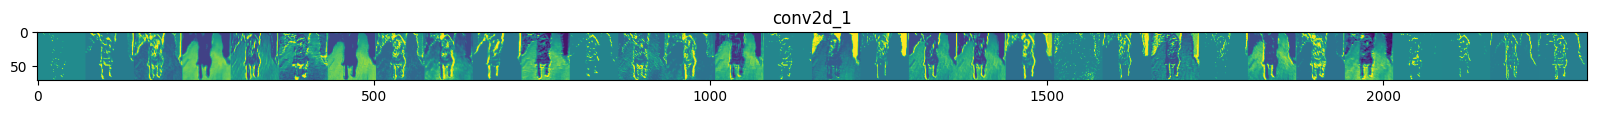

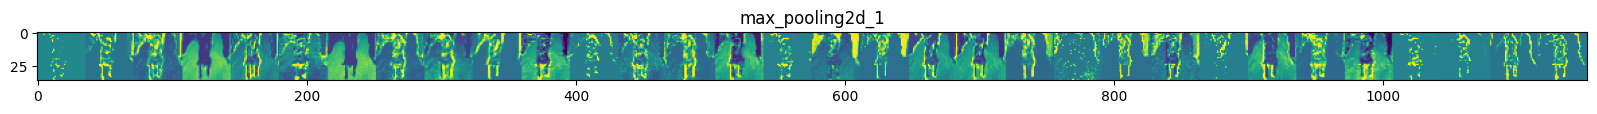

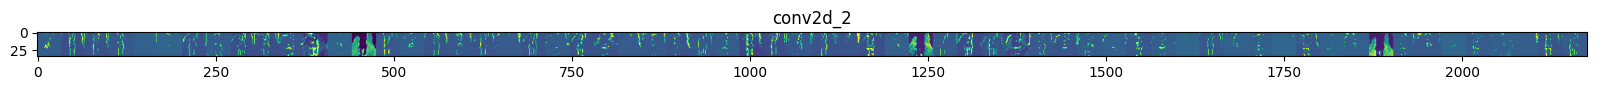

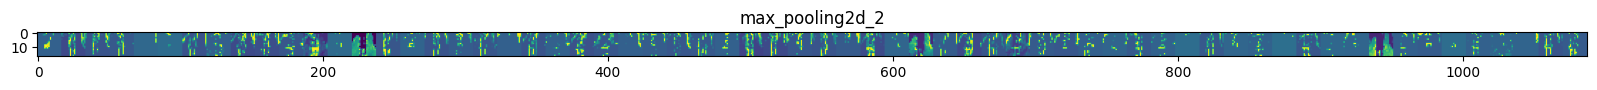

In [18]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output intermediate representations for all layers in the previous model after the first
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(img_input, successive_outputs) # Takes in the original image input and successive outputs, which is an array of the output of all the layers in the model after the first

# Let's prepate a random input iamge of a cat or a dog from the training set
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
img_path = random.choice(cat_img_files + dog_img_files)

img = load_img(img_path, target_size=(150, 150)) # This is a PIL image
x = img_to_array(img) # Numpy array with shape (1, 150, 150, 3)
x = x.reshape((1,) + x.shape) # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x = x / 255

# Let's run our image through our network, thus obtaining all intermediate representation for this image
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers[1:]]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:
        # Just do this for the conv / maxpool layers, not the fully connected layers
        n_features = feature_map.shape[-1] # number of features in feature map
        
        # The feature map has shape (1, size, size, n_features)
        size = feature_map.shape[1]

        # We will tile our images in this matrix
        display_grid = np.zeros((size, size * n_features))

        for i in range(n_features):
            # Postprocess the feature to make it visually palatable
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *=64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')

            # We'll tile each filter into this big horizontal grid
            display_grid[:, i * size : (i + 1) * size] = x

        # Display the grid
        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect="auto", cmap="viridis")


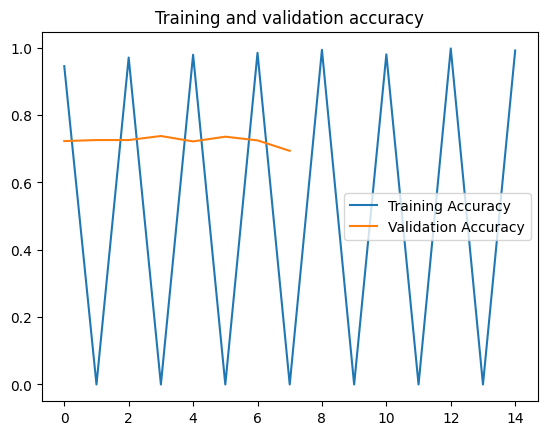

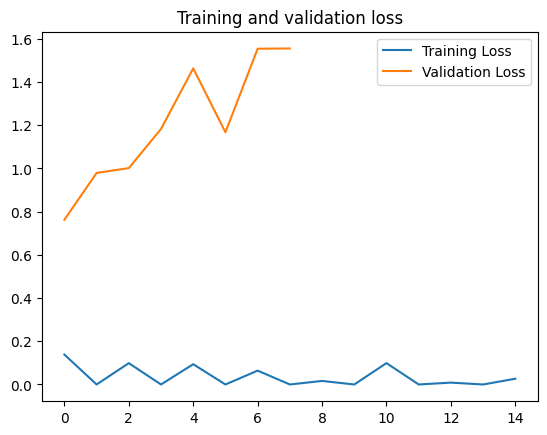

In [24]:
## Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

import numpy as np

# Pad val_acc and val_loss with None or np.nan to match the length of acc
padded_val_acc = val_acc + [None] * (len(acc) - len(val_acc))
padded_val_loss = val_loss + [None] * (len(loss) - len(val_loss))

epochs = range(len(acc))  # Use full range of epochs (15)

# Plot training and validation accuracy
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, padded_val_acc, label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Plot training and validation loss
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, padded_val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
